### Construct simulation network

In [ ]:
### import packages 
from brian2 import *
from brian2.units import *
from brian2 import ms
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
import json

from simulation_runner import plot_results, run_simulation, load_params

In [ ]:
### STN (I = 100)
json_file = './params_ref/STN_1.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value'] 

# simulation 
results = run_simulation(N, params, model_name)

# visualization
plot_results(results)

In [ ]:
### GPe (I = 100)
json_file = './params_ref/GPe_T1_1.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value'] 

# simulation 
results = run_simulation(N, params, model_name)

# visualization
plot_results(results)

In [ ]:
### MSN (I = 100)
json_file = './params_ref/MSN_D2_1.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value'] 

# simulation 
results = run_simulation(N, params, model_name)

# visualization
plot_results(results)

### Striatum - GPe - STN - Cortex

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    'u' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value array([], shape=(10, 0), dtype=float64) * amp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value array([], shape=(10, 0), dtype=float64) * volt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'u' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value array([], shape=(10, 0), dtype=float64) * amp. The internal variable will be used. [brian2.g

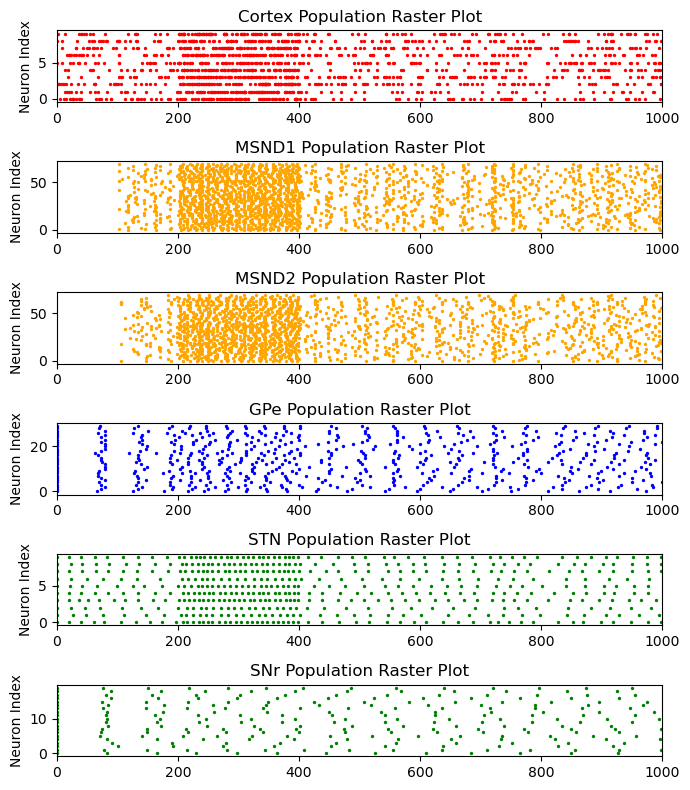

In [1]:

### Result with inh/ext input with only one neuron
from simulation_runner_syn import run_simulation_with_inh_ext_input, plot_results_pre_post, plot_raster, plot_results_I
from brian2 import *

gpe_params_file = './params_ref/GPe_T1_1.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1.json' 

synapse_params = {
    # STN - GPe (ext)
    'g0_a': 0.35*nS,
    'ampa_tau_syn': 12*ms,  
    'ampa_E_rev': 0*mV,
    
    # D2 - GPe
    'g0_g': 2*nS,
    'gaba_tau_syn': 6 * ms,
    'gaba_E_rev': -65 * mV,
    
    # Cortex - D1
    'cs1_g0_a': 0.5 * nS,
    'cs1_g0_n': 0.11 * nS,
    'cs1_ampa_tau_syn': 12 * ms,
    'cs1_nmda_tau_syn': 160 * ms,
    'cs1_ampa_E_rev': 0 * mV,
    'cs1_nmda_E_rev': 0 * mV,
    
    # Cortex - D2
    'cs_g0_a': 0.5 * nS,
    'cs_g0_n': 0.019 * nS,
    'cs_ampa_tau_syn': 12 * ms,
    'cs_nmda_tau_syn': 160 * ms,
    'cs_ampa_E_rev': 0 * mV,
    'cs_nmda_E_rev': 0 * mV,
    
    # Cortex - STN (excitatory connection)
    'csn_g0_a': 0.25 * nS,
    'csn_g0_n': 0.00625 * nS,
    'csn_ampa_tau_syn': 4 * ms,
    'csn_nmda_tau_syn': 160 * ms,
    'csn_ampa_E_rev': 0 * mV,
    'csn_nmda_E_rev': 0 * mV,
    
    # GPe - STN
    'gsn_g0_g': 0.08*nS,
    'gsn_gaba_tau_syn': 8 * ms,
    'gsn_gaba_E_rev': -84 * mV,
    
    # GPe - SNr
    'gsnr_g0_g': 76*nS, 
    'gsnr_gaba_tau_syn': 2.1 * ms, 
    'gsnr_gaba_E_rev': -72 * mV,
    
    # D1 - SNr
    'd1snr_g0_g': 2*nS,
    'd1snr_gaba_tau_syn': 5.2 * ms,
    'd1snr_gaba_E_rev': -80 * mV,
    
    # STN - SNr
    'snsnr_g0_a':0.91 * nS,
    'snsnr_ampa_tau_syn': 12 * ms,
    'snsnr_ampa_E_rev':0 * mV
}

N_GPe = 30 # 988
N_STN = 10 # 388
N_MSN = 70 # 37971
N_SNr = 20 # 754

results = run_simulation_with_inh_ext_input(
    N_GPe,
    N_STN,
    N_MSN,
    N_SNr,
    gpe_params_file,
    stn_params_file,
    msnd1_params_file,
    msnd2_params_file,
    snr_params_file, 
    synapse_params,
    'GPe', 
    'STN', 
    'MSND1',
    'MSND2',
    'SNr',
    "GPe_STN_inh_ext"
)

plot_raster(results)

In [ ]:
### Dopamine removal effect (D1) 
from simulation_runner_syn import run_simulation_with_inh_ext_input, plot_results_pre_post, plot_raster, plot_results_I
from brian2 import *

gpe_params_file = './params_ref/GPe_T1_1.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1_dop.json' 
msnd2_params_file = './params_ref/MSN_D2_1.json' 
snr_params_file = './params_ref/SNr_1.json' 

synapse_params = {
    # STN - GPe (ext)
    'g0_a': 0.35*nS,
    'ampa_tau_syn': 12*ms,  
    'ampa_E_rev': 0*mV,
    
    # D2 - GPe
    'g0_g': 2*nS,
    'gaba_tau_syn': 6 * ms,
    'gaba_E_rev': -65 * mV,
    
    # Cortex - D1
    'cs1_g0_a': 0.5 * nS,
    'cs1_g0_n': 0.11 * nS,
    'cs1_ampa_tau_syn': 12 * ms,
    'cs1_nmda_tau_syn': 160 * ms,
    'cs1_ampa_E_rev': 0 * mV,
    'cs1_nmda_E_rev': 0 * mV,
    
    # Cortex - D2
    'cs_g0_a': 0.5 * nS,
    'cs_g0_n': 0.019 * nS,
    'cs_ampa_tau_syn': 12 * ms,
    'cs_nmda_tau_syn': 160 * ms,
    'cs_ampa_E_rev': 0 * mV,
    'cs_nmda_E_rev': 0 * mV,
    
    # Cortex - STN (excitatory connection)
    'csn_g0_a': 0.25 * nS,
    'csn_g0_n': 0.00625 * nS,
    'csn_ampa_tau_syn': 4 * ms,
    'csn_nmda_tau_syn': 160 * ms,
    'csn_ampa_E_rev': 0 * mV,
    'csn_nmda_E_rev': 0 * mV,
    
    # GPe - STN
    'gsn_g0_g': 0.08*nS,
    'gsn_gaba_tau_syn': 8 * ms,
    'gsn_gaba_E_rev': -84 * mV,
    
    # GPe - SNr
    'gsnr_g0_g': 76*nS, 
    'gsnr_gaba_tau_syn': 2.1 * ms, 
    'gsnr_gaba_E_rev': -72 * mV,
    
    # D1 - SNr
    'd1snr_g0_g': 2*nS,
    'd1snr_gaba_tau_syn': 5.2 * ms,
    'd1snr_gaba_E_rev': -80 * mV,
    
    # STN - SNr
    'snsnr_g0_a':0.91 * nS,
    'snsnr_ampa_tau_syn': 12 * ms,
    'snsnr_ampa_E_rev':0 * mV
}

N_GPe = 30 # 988
N_STN = 10 # 388
N_MSN = 70 # 37971
N_SNr = 20 # 754

results = run_simulation_with_inh_ext_input(
    N_GPe,
    N_STN,
    N_MSN,
    N_SNr,
    gpe_params_file,
    stn_params_file,
    msnd1_params_file,
    msnd2_params_file,
    snr_params_file, 
    synapse_params,
    'GPe', 
    'STN', 
    'MSND1',
    'MSND2',
    'SNr',
    "GPe_STN_inh_ext_dop"
)

plot_raster(results)

In [ ]:
### various input current visualization 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Import colormap module

# Time vector from 0 to 1000 ms
time = np.arange(0, 1000, 1)

# Initialize current arrays for each step
current_50 = np.zeros_like(time)
current_100 = np.zeros_like(time)
current_150 = np.zeros_like(time)
current_200 = np.zeros_like(time)
current_250 = np.zeros_like(time)

# Set current values between 200 ms and 400 ms for each current step
current_50[200:400] = 50
current_100[200:400] = 100
current_150[200:400] = 150
current_200[200:400] = 200
current_250[200:400] = 250

colors = cm.Blues(np.linspace(0.3, 1, 5))  # Adjust the range to get lighter to darker blue

# Create the plot
plt.figure(figsize=(12, 5))

# Plot each current with a different label and line style
plt.plot(time, current_50, label='I = 50 pA', linewidth=2, color=colors[0])
plt.plot(time, current_100, label='I = 100 pA', linewidth=2, color=colors[1])
plt.plot(time, current_150, label='I = 150 pA', linewidth=2, color=colors[2])
plt.plot(time, current_200, label='I = 200 pA', linewidth=2, color=colors[3])
plt.plot(time, current_250, label='I = 250 pA', linewidth=2, color=colors[4])

# Labels and title
plt.xlabel('Time (ms)')
plt.ylabel('I (pA)')
# plt.title('Input Currents for Different Current Levels')
plt.legend()

# Display the plot
plt.show()



In [ ]:
### noisy + poisson input visualization 

# Simulation parameters
duration = 1000  # Total duration in ms
time = np.arange(0, duration, 1)  # Time vector in ms
base_rate = 10  # Base rate in Hz
increase_rate = 100  # Increased rate during 200-400 ms
sigma = 3  # Standard deviation for noise

# Initialize the firing rates array
firing_rates = np.zeros_like(time, dtype=float)

# Define the input pattern
for t in range(len(time)):
    if 200 <= time[t] < 400:
        firing_rates[t] = base_rate + increase_rate  # 200 to 400 ms
    else:
        firing_rates[t] = base_rate  # Outside the interval

# Add noise to the firing rates
noise = np.random.normal(0, sigma, size=firing_rates.shape)
firing_rates_with_noise = firing_rates + noise

# Ensure firing rates are non-negative
firing_rates_with_noise[firing_rates_with_noise < 0] = 0

# Plot the firing rates
plt.figure(figsize=(12, 5))
# plt.plot(time, firing_rates, label='Firing Rate (Without Noise)', color='b', linewidth=2)
plt.plot(time, firing_rates_with_noise, color='orange', alpha=0.7)
plt.xlabel('Time (ms)') 
plt.ylabel('Firing Rate (Hz)')
# plt.title('Cortex Neuron Firing Rate Pattern')
#plt.grid()
plt.xlim(0, duration)  # Set x-axis limits
plt.ylim(0, np.max(firing_rates_with_noise) + 10)  # Set y-axis limits
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_neuron_connections(results, N_GPe, N_STN, N_MSN, N_SNr):

    plt.figure(figsize=(18, 10))

    G = nx.DiGraph()

    # Add nodes for each neuron group
    G.add_nodes_from(range(N_GPe), group='GPe')
    G.add_nodes_from(range(N_GPe, N_GPe + N_STN), group='STN')
    G.add_nodes_from(range(N_GPe + N_STN, N_GPe + N_STN + N_MSN, N_SNr), group='Striatum')

    # Add edges 
    for i in range(N_GPe):
        G.add_edge(i, N_GPe + (i % N_STN))  # GPe to STN
    for i in range(N_STN):
        G.add_edge(N_GPe + i, N_GPe + N_STN + (i % N_MSN))  # STN to Striatum

    # Circular layout to reduce overlap and improve aesthetics
    pos = nx.circular_layout(G)

    # Define node colors for different groups
    node_colors = ['#FF9999'] * N_GPe + ['#99CCFF'] * N_STN + ['#99FF99'] * N_MSN

    # Define node shapes
    node_shapes = {
        'GPe': 'o',  
        'STN': 's', 
        'Striatum': '^'  
    }

    # Draw nodes with different colors and shapes
    for group, shape in node_shapes.items():
        group_indices = [n for n, d in G.nodes(data=True) if d['group'] == group]
        nx.draw_networkx_nodes(G, pos, nodelist=group_indices, node_color=[node_colors[i] for i in group_indices],
                               node_size=800, node_shape=shape, label=group)

    # Draw edges with different colors for connections between neuron groups
    edge_colors = ['#FF6666' if G.nodes[u]['group'] == 'GPe' else '#6666FF' for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowstyle='->', arrowsize=15, width=2)

    # Add labels
    labels = {i: f"GPe {i}" if i < N_GPe else f"STN {i - N_GPe}" if i < N_GPe + N_STN else f"Striatum {i - N_GPe - N_STN}" for i in range(N_GPe + N_STN + N_Striatum)}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

    # Create a legend
    legend_labels = ['GPe', 'STN', 'Striatum']
    legend_colors = ['#FF9999', '#99CCFF', '#99FF99']
    for label, color in zip(legend_labels, legend_colors):
        plt.scatter([], [], c=color, label=label, s=100)
    plt.legend(loc='best')

    # Display the graph
    plt.title('Neuron Connectivity: GPe -> STN -> Striatum', fontsize=12)
    plt.gca().set_facecolor('white')  
    plt.show()


plot_neuron_connections(results, N_GPe, N_STN, N_Striatum)

In [ ]:
# Firing rate plot with dopamine removal effect (D1)
import numpy as np
import matplotlib.pyplot as plt
from simulation_runner_syn import run_simulation_with_inh_ext_input, plot_raster
from brian2 import *

n_simulations = 10  # Number of repeated simulations

# Firing rate storage
firing_rates_per_neuron = {
    'gpe': np.zeros(n_simulations),
    'STN': np.zeros(n_simulations),
    'MSND1': np.zeros(n_simulations),
    'MSND2': np.zeros(n_simulations),
    'SNr': np.zeros(n_simulations)
}

# Parameter files
gpe_params_file = './params_ref/GPe_T1_1.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file = './params_ref/MSN_D1_1.json'
msnd2_params_file = './params_ref/MSN_D2_1.json'
snr_params_file = './params_ref/SNr_1.json'

synapse_params = {
    # STN - GPe (ext)
    'g0_a': 0.35*nS,
    'ampa_tau_syn': 12*ms,  
    'ampa_E_rev': 0*mV,
    
    # D2 - GPe
    'g0_g': 2*nS,
    'gaba_tau_syn': 6 * ms,
    'gaba_E_rev': -65 * mV,
    
    # Cortex - D1
    'cs1_g0_a': 0.5 * nS,
    'cs1_g0_n': 0.11 * nS,
    'cs1_ampa_tau_syn': 12 * ms,
    'cs1_nmda_tau_syn': 160 * ms,
    'cs1_ampa_E_rev': 0 * mV,
    'cs1_nmda_E_rev': 0 * mV,
    
    # Cortex - D2
    'cs_g0_a': 0.5 * nS,
    'cs_g0_n': 0.019 * nS,
    'cs_ampa_tau_syn': 12 * ms,
    'cs_nmda_tau_syn': 160 * ms,
    'cs_ampa_E_rev': 0 * mV,
    'cs_nmda_E_rev': 0 * mV,
    
    # Cortex - STN (excitatory connection)
    'csn_g0_a': 0.25 * nS,
    'csn_g0_n': 0.00625 * nS,
    'csn_ampa_tau_syn': 4 * ms,
    'csn_nmda_tau_syn': 160 * ms,
    'csn_ampa_E_rev': 0 * mV,
    'csn_nmda_E_rev': 0 * mV,
    
    # GPe - STN
    'gsn_g0_g': 0.08*nS,
    'gsn_gaba_tau_syn': 8 * ms,
    'gsn_gaba_E_rev': -84 * mV,
    
    # GPe - SNr
    'gsnr_g0_g': 76*nS, 
    'gsnr_gaba_tau_syn': 2.1 * ms, 
    'gsnr_gaba_E_rev': -72 * mV,
    
    # D1 - SNr
    'd1snr_g0_g': 2*nS,
    'd1snr_gaba_tau_syn': 5.2 * ms,
    'd1snr_gaba_E_rev': -80 * mV,
    
    # STN - SNr
    'snsnr_g0_a':0.91 * nS,
    'snsnr_ampa_tau_syn': 12 * ms,
    'snsnr_ampa_E_rev':0 * mV
}

N_GPe = 30  # GPe neurons
N_STN = 10  # STN neurons
N_MSN = 70  # MSN neurons (D1 and D2)
N_SNr = 20  # SNr neurons

# Run simulations
for i in range(n_simulations):
    results = run_simulation_with_inh_ext_input(
        N_GPe, N_STN, N_MSN, N_SNr,
        gpe_params_file, stn_params_file, msnd1_params_file,
        msnd2_params_file, snr_params_file, synapse_params,
        'GPe', 'STN', 'MSND1', 'MSND2', 'SNr', "GPe_STN_inh_ext"
    )

    # Save mean firing rates
    firing_rates_per_neuron['gpe'][i] = np.mean(results['firing_rates']['gpe'])
    firing_rates_per_neuron['STN'][i] = np.mean(results['firing_rates']['STN'])
    firing_rates_per_neuron['MSND1'][i] = np.mean(results['firing_rates']['msnd1'])
    firing_rates_per_neuron['MSND2'][i] = np.mean(results['firing_rates']['msnd2'])
    firing_rates_per_neuron['SNr'][i] = np.mean(results['firing_rates']['snr'])

# Mean and standard deviation of firing rates
mean_firing_rates = {key: np.mean(firing_rates_per_neuron[key]) for key in firing_rates_per_neuron}
std_firing_rates = {key: np.std(firing_rates_per_neuron[key]) for key in firing_rates_per_neuron}

# Visualization
plt.figure(figsize=(10, 6))
x = np.arange(len(mean_firing_rates))
labels = list(mean_firing_rates.keys())

# Bar plot with error bars
bars = plt.bar(x, mean_firing_rates.values(), yerr=std_firing_rates.values(),
               capsize=5, edgecolor='black', fill=False, alpha=0.7)

# Plot individual spike rates as blue dots
for idx, (key, rates) in enumerate(firing_rates_per_neuron.items()):
    plt.scatter([idx] * n_simulations, rates, color='blue', alpha=0.5, label=f'{key} Spike Rates')

plt.xlabel('Neuron Type')
plt.ylabel('Mean Firing Rate (Hz)')
plt.title('Mean Firing Rate of Neuron Types with Error Bars (Std Dev)')
plt.xticks(x, labels)
plt.tight_layout()
plt.show()

# Plot the raster plot of results (optional)
plot_raster(results)


In [ ]:
# Firing rate plot 
import numpy as np
import matplotlib.pyplot as plt
from simulation_runner_syn import run_simulation_with_inh_ext_input, plot_results_pre_post, plot_raster, plot_results_I
from brian2 import *

n_neurons = 30  
n_simulations = 10  

# set list 
firing_rates_per_neuron = {
    'gpe': np.zeros(n_simulations),
    'STN': np.zeros(n_simulations),
    'cortex': np.zeros(n_simulations),
    'striatum': np.zeros(n_simulations)
}

gpe_params_file = './params_ref/GPe_T1_1.json'
stn_params_file = './params_ref/STN_1.json'
striatum_params_file = './params_ref/MSN_D2_1.json' 

synapse_params = {
    # STN - GPe (ext)
    'g0_n': 0.08*nS,
    'nmda_tau_syn': 100*ms,  
    'nmda_E_rev': 0*mV,
    'g0_a': 0.35*nS,
    'ampa_tau_syn': 12*ms,  
    'ampa_E_rev': 0*mV,
    
    # EXT - GPe
    'g0_g': 0.04*nS,
    'gaba_tau_syn': 87 * ms,
    'gaba_E_rev': -74* mV,
    
    # Cortex - EXT
    'cs_g0_n': 0.11 * nS,
    'cs_g0_a': 0.5 * nS,
    'cs_ampa_tau_syn': 12 * ms,
    'cs_nmda_tau_syn': 160 * ms,
    'cs_ampa_E_rev': 0 * mV,
    'cs_nmda_E_rev': 0 * mV,
    
    # Cortex - STN (excitatory connection)
    'csn_g0_n': 0.00625 * nS,
    'csn_g0_a': 0.25 * nS,
    'csn_ampa_tau_syn': 4 * ms,
    'csn_nmda_tau_syn': 160 * ms,
    'csn_ampa_E_rev': 0 * mV,
    'csn_nmda_E_rev': 0 * mV,
    
    # GPe - STN
    'gsn_g0_g': 0.08*nS,
    'gsn_gaba_tau_syn': 8 * ms,
    'gsn_gaba_E_rev': -84 * mV
}

N_GPe = 30 # 988
N_STN = 10 # 388
N_Striatum = 30 # 37971

# repeat simulation 
for i in range(n_simulations):
    results = run_simulation_with_inh_ext_input(  
        N_GPe, N_STN, N_Striatum, gpe_params_file, stn_params_file, striatum_params_file,
        synapse_params, 'GPe', 'STN', 'Striatum', "GPe_STN_inh_ext"
    )
    
    # 각 뉴런 타입의 firing rate 저장
    firing_rates_per_neuron['gpe'][i] = np.mean(results['firing_rates']['gpe'])  # 평균값으로 저장
    firing_rates_per_neuron['STN'][i] = np.mean(results['firing_rates']['STN'])  # 평균값으로 저장
    firing_rates_per_neuron['cortex'][i] = np.mean(results['firing_rates']['cortex'])  # 평균값으로 저장
    firing_rates_per_neuron['striatum'][i] = np.mean(results['firing_rates']['striatum'])  # 평균값으로 저장

# mean & variance 
mean_firing_rates = {key: np.mean(firing_rates_per_neuron[key]) for key in firing_rates_per_neuron}
std_firing_rates = {key: np.std(firing_rates_per_neuron[key]) for key in firing_rates_per_neuron}

# visualization 
plt.figure(figsize=(10, 6))
x = np.arange(len(mean_firing_rates)) 
labels = list(mean_firing_rates.keys()) 

bars = plt.bar(x, mean_firing_rates.values(), yerr=std_firing_rates.values(), 
               capsize = 5, edgecolor = 'black', fill = False, alpha = 0.7)

for idx, (key, rates) in enumerate(firing_rates_per_neuron.items()):
    plt.scatter([idx] * n_simulations, rates, color='blue', alpha=0.5, label=f'{key} Spike Rates')

"""
for i in range(len(labels)):
    plt.text(i, mean_firing_rates[labels[i]] + std_firing_rates[labels[i]] + 0.1, 
             f'{mean_firing_rates[labels[i]]:.2f}', ha='center')
"""

plt.xlabel('Neuron Type')
plt.ylabel('Mean Firing Rate (Hz)')
plt.title('Mean Firing Rate of Neuron Types with Error Bars (Std Dev)')
plt.xticks(x, labels) 
plt.tight_layout()
plt.show()

In [ ]:
# Firing rate plot with dopamine removal effect (D1) - Two scenarios comparison
import numpy as np
import matplotlib.pyplot as plt
from simulation_runner_syn import run_simulation_with_inh_ext_input, plot_raster
from brian2 import *

n_simulations = 10  # Number of repeated simulations

# Firing rate storage for both scenarios
firing_rates_per_neuron_scenario_1 = {
    'gpe': np.zeros(n_simulations),
    'STN': np.zeros(n_simulations),
    'MSND1': np.zeros(n_simulations),
    'MSND2': np.zeros(n_simulations),
    'SNr': np.zeros(n_simulations)
}

firing_rates_per_neuron_scenario_2 = {
    'gpe': np.zeros(n_simulations),
    'STN': np.zeros(n_simulations),
    'MSND1': np.zeros(n_simulations),
    'MSND2': np.zeros(n_simulations),
    'SNr': np.zeros(n_simulations)
}

# Parameter files for the second scenario
gpe_params_file = './params_ref/GPe_T1_1.json'
stn_params_file = './params_ref/STN_1.json'
msnd1_params_file_scenario_1 = './params_ref/MSN_D1_1.json'
msnd1_params_file_scenario_2 = './params_ref/MSN_D1_1_dop.json'  # Modified D1 params for scenario 2
msnd2_params_file = './params_ref/MSN_D2_1.json'
snr_params_file = './params_ref/SNr_1.json'

synapse_params = {
    # Same synaptic parameters as before    'g0_a': 0.35*nS,
    'g0_a': 0.35*nS,
    'ampa_tau_syn': 12*ms,  
    'ampa_E_rev': 0*mV,
    
    # D2 - GPe
    'g0_g': 2*nS,
    'gaba_tau_syn': 6 * ms,
    'gaba_E_rev': -65 * mV,
    
    # Cortex - D1
    'cs1_g0_a': 0.5 * nS,
    'cs1_g0_n': 0.11 * nS,
    'cs1_ampa_tau_syn': 12 * ms,
    'cs1_nmda_tau_syn': 160 * ms,
    'cs1_ampa_E_rev': 0 * mV,
    'cs1_nmda_E_rev': 0 * mV,
    
    # Cortex - D2
    'cs_g0_a': 0.5 * nS,
    'cs_g0_n': 0.019 * nS,
    'cs_ampa_tau_syn': 12 * ms,
    'cs_nmda_tau_syn': 160 * ms,
    'cs_ampa_E_rev': 0 * mV,
    'cs_nmda_E_rev': 0 * mV,
    
    # Cortex - STN (excitatory connection)
    'csn_g0_a': 0.25 * nS,
    'csn_g0_n': 0.00625 * nS,
    'csn_ampa_tau_syn': 4 * ms,
    'csn_nmda_tau_syn': 160 * ms,
    'csn_ampa_E_rev': 0 * mV,
    'csn_nmda_E_rev': 0 * mV,
    
    # GPe - STN
    'gsn_g0_g': 0.08*nS,
    'gsn_gaba_tau_syn': 8 * ms,
    'gsn_gaba_E_rev': -84 * mV,
    
    # GPe - SNr
    'gsnr_g0_g': 76*nS, 
    'gsnr_gaba_tau_syn': 2.1 * ms, 
    'gsnr_gaba_E_rev': -72 * mV,
    
    # D1 - SNr
    'd1snr_g0_g': 2*nS,
    'd1snr_gaba_tau_syn': 5.2 * ms,
    'd1snr_gaba_E_rev': -80 * mV,
    
    # STN - SNr
    'snsnr_g0_a':0.91 * nS,
    'snsnr_ampa_tau_syn': 12 * ms,
    'snsnr_ampa_E_rev':0 * mV
    }

N_GPe = 30  # GPe neurons
N_STN = 10  # STN neurons
N_MSN = 70  # MSN neurons (D1 and D2)
N_SNr = 20  # SNr neurons

# Run simulations for Scenario 1
for i in range(n_simulations):
    results = run_simulation_with_inh_ext_input(
        N_GPe, N_STN, N_MSN, N_SNr,
        gpe_params_file, stn_params_file, msnd1_params_file_scenario_1,
        msnd2_params_file, snr_params_file, synapse_params,
        'GPe', 'STN', 'MSND1', 'MSND2', 'SNr', "GPe_STN_inh_ext"
    )

    # Save mean firing rates for scenario 1
    firing_rates_per_neuron_scenario_1['gpe'][i] = np.mean(results['firing_rates']['gpe'])
    firing_rates_per_neuron_scenario_1['STN'][i] = np.mean(results['firing_rates']['STN'])
    firing_rates_per_neuron_scenario_1['MSND1'][i] = np.mean(results['firing_rates']['msnd1'])
    firing_rates_per_neuron_scenario_1['MSND2'][i] = np.mean(results['firing_rates']['msnd2'])
    firing_rates_per_neuron_scenario_1['SNr'][i] = np.mean(results['firing_rates']['snr'])

# Run simulations for Scenario 2 (with modified MSND1 params)
for i in range(n_simulations):
    results = run_simulation_with_inh_ext_input(
        N_GPe, N_STN, N_MSN, N_SNr,
        gpe_params_file, stn_params_file, msnd1_params_file_scenario_2,
        msnd2_params_file, snr_params_file, synapse_params,
        'GPe', 'STN', 'MSND1', 'MSND2', 'SNr', "GPe_STN_inh_ext"
    )

    # Save mean firing rates for scenario 2
    firing_rates_per_neuron_scenario_2['gpe'][i] = np.mean(results['firing_rates']['gpe'])
    firing_rates_per_neuron_scenario_2['STN'][i] = np.mean(results['firing_rates']['STN'])
    firing_rates_per_neuron_scenario_2['MSND1'][i] = np.mean(results['firing_rates']['msnd1'])
    firing_rates_per_neuron_scenario_2['MSND2'][i] = np.mean(results['firing_rates']['msnd2'])
    firing_rates_per_neuron_scenario_2['SNr'][i] = np.mean(results['firing_rates']['snr'])

# Calculate means and standard deviations for both scenarios
mean_firing_rates_scenario_1 = {key: np.mean(firing_rates_per_neuron_scenario_1[key]) for key in firing_rates_per_neuron_scenario_1}
std_firing_rates_scenario_1 = {key: np.std(firing_rates_per_neuron_scenario_1[key]) for key in firing_rates_per_neuron_scenario_1}

mean_firing_rates_scenario_2 = {key: np.mean(firing_rates_per_neuron_scenario_2[key]) for key in firing_rates_per_neuron_scenario_2}
std_firing_rates_scenario_2 = {key: np.std(firing_rates_per_neuron_scenario_2[key]) for key in firing_rates_per_neuron_scenario_2}

# Plot the results
plt.figure(figsize=(12, 6))
x = np.arange(len(mean_firing_rates_scenario_1))
width = 0.35  # Width of the bars

labels = list(mean_firing_rates_scenario_1.keys())

# Plot bars for Scenario 1
bars1 = plt.bar(x - width/2, mean_firing_rates_scenario_1.values(), width, yerr=std_firing_rates_scenario_1.values(),
                label='Scenario 1', capsize=5, edgecolor='black', fill=False, alpha=0.7)

# Plot bars for Scenario 2
bars2 = plt.bar(x + width/2, mean_firing_rates_scenario_2.values(), width, yerr=std_firing_rates_scenario_2.values(),
                label='Scenario 2', capsize=5, edgecolor='black', fill=False, alpha=0.7, color='green')

# Add labels and titles
plt.xlabel('Neuron Type')
plt.ylabel('Mean Firing Rate (Hz)')
plt.title('Comparison of Mean Firing Rates between Two Scenarios')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

# Plot raster plots for both scenarios (optional)
plot_raster(results)

In [ ]:
# vis (firing rate): https://kordinglab.com/spykes/auto_examples/plot_neuropop_simul_example.html#simulate-a-population-of-neurons